# Green House Gas Emissions
In this notebook we will predict GHG-emissions based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure
- Cleaning and assessing GHG-emission data 
- Log-transforming GHG data
- Combining GHG data with Predictor data
- Exploring correlations with the predictor data 
- Splitting the combined dataset in training, validation and testing data
    - With our outcome variable (GHG) lagged by 5 years
- Fitting baseline model (mean model)
- Fitting simple mixed effects model (time, population, countrysize)
- Fitting simple mixed effects models with each predictor seperately (time, population, countrysize, predictor_xyzab)
- Fitting theory driven mixed effects model of social (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting theory driven mixed effects model of governance (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting a mixed effects decision tree model, random forest with all predictors
- Compare model predictions 


In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import os

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
import statsmodels.formula.api as smf

# Cleaning and combining data 

In [105]:
#Read file 
df = pd.read_csv('Data/ghg-emissions.csv')

In [106]:
#clean data 
df.drop([193, 194], inplace=True)

melted_df = pd.melt(df, id_vars=['iso', 'Country/Region', 'unit'], var_name='Year', value_name='ghg')

#print(melted_df)

In [107]:
melted_df.describe()

,iso,Country/Region,unit,Year,ghg
count,5983,5983,5983,5983,5983.00
unique,193,193,1,31,4569.00
top,CHN,China,MtCO2e,1990,0.02
freq,31,31,5983,193,29.00


In [108]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   iso             5983 non-null   object
 1   Country/Region  5983 non-null   object
 2   unit            5983 non-null   object
 3   Year            5983 non-null   object
 4   ghg             5983 non-null   object
dtypes: object(5)
memory usage: 233.8+ KB


In [109]:
melted_df.replace('false', np.nan, inplace=True)
melted_df['Year'] = melted_df['Year'].astype(float)
melted_df['ghg'] = melted_df['ghg'].astype(float)

In [110]:

melted_df.dropna()
print(melted_df)

      iso Country/Region    unit    Year      ghg
0     CHN          China  MtCO2e  1990.0  2892.41
1     USA  United States  MtCO2e  1990.0  5448.74
2     IND          India  MtCO2e  1990.0  1020.11
3     RUS         Russia  MtCO2e  1990.0  2624.74
4     IDN      Indonesia  MtCO2e  1990.0  1140.84
...   ...            ...     ...     ...      ...
5978  COK   Cook Islands  MtCO2e  2020.0     0.07
5979  NRU          Nauru  MtCO2e  2020.0     0.05
5980  TUV         Tuvalu  MtCO2e  2020.0     0.02
5981  NIU           Niue  MtCO2e  2020.0     0.00
5982  FJI           Fiji  MtCO2e  2020.0    -0.81

[5983 rows x 5 columns]


KeyboardInterrupt: 

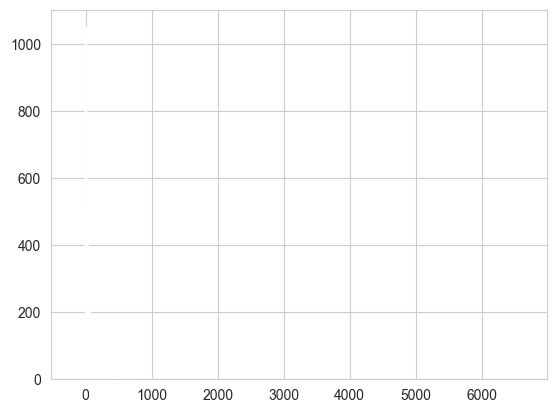

In [111]:
sns.histplot(data=melted_df, x='ghg', binwidth=10)
plt.show()

We need to transform our variable, so that the most polluting countries don't weigh to much. 

In [ ]:
#Making a list for all countries that have exactly 0.0 percent ghg. 

zero_countries = melted_df.groupby('iso')['ghg'].sum()

zero_countries = zero_countries[zero_countries == 0.0].index.tolist()

print(zero_countries)

[]


Removing NIU, becuase it contains 0 values of GHG. 

In [ ]:
#Defining the country to remove
countries_to_remove = ['NIU'] 

#Filtering the DataFrame to remove the specified countries
melted_df = melted_df[~melted_df['iso'].isin(countries_to_remove)]

In [ ]:
#Log transform
melted_df['log_ghg'] = np.log(melted_df['ghg'])

# Check the result
print(melted_df.head())




   iso Country/Region    unit    Year      ghg   log_ghg
0  CHN          China  MtCO2e  1990.0  2892.41  7.969845
1  USA  United States  MtCO2e  1990.0  5448.74  8.603140
2  IND          India  MtCO2e  1990.0  1020.11  6.927666
3  RUS         Russia  MtCO2e  1990.0  2624.74  7.872737
4  IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520


c:\Users\mlj\OneDrive - Aarhus Universitet\MA 2. Semester\Data Science\DataScienceExam\data_sci_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


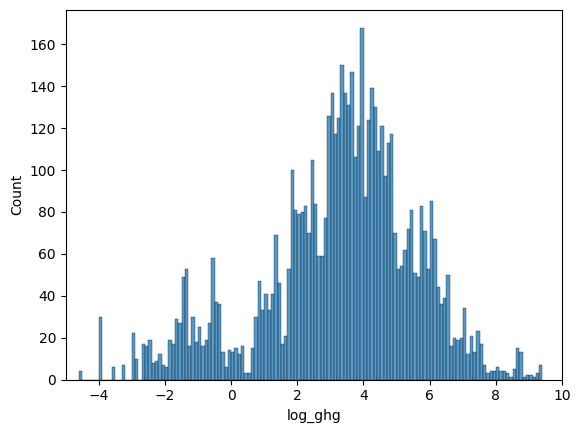

In [ ]:
sns.histplot(data=melted_df, x='log_ghg', binwidth=0.1)
# Setting x-axis limit
plt.xlim(left=-5)
plt.xlim(right=10)
plt.show()

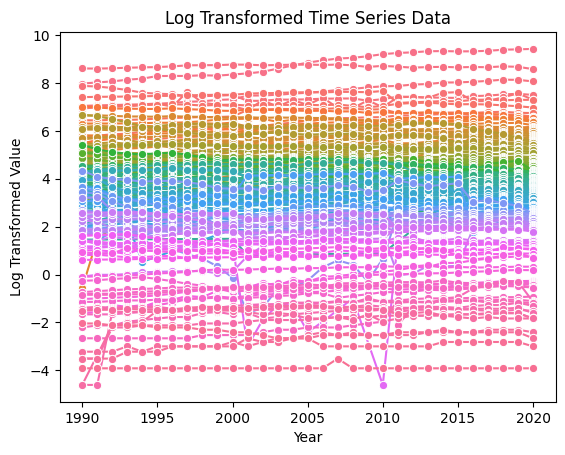

In [ ]:
sns.lineplot(data=melted_df, x='Year', y='log_ghg', hue='iso', marker='o', legend=False)

# Add title and labels
plt.title('Log Transformed Time Series Data')
plt.xlabel('Year')
plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

In [ ]:
print(melted_df.isna().sum())

iso               0
Country/Region    0
unit              0
Year              0
ghg               1
dtype: int64


In [ ]:
display(melted_df)

,iso,Country/Region,unit,Year,ghg,log_ghg
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140
2,IND,India,MtCO2e,1990.0,1020.11,6.927666
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520
...,...,...,...,...,...,...
5977,KIR,Kiribati,MtCO2e,2020.0,0.09,-2.407946
5978,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260
5979,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732
5980,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023


### Add predictors to our GHG-dataset

In [ ]:
#Read predictor file 

pred = pd.read_excel('git_data/predictor_data.xlsx')

print(pred)

                      Country Name Country Code  Year  Population, total  \
0                            Aruba          ABW  1960            54608.0   
1      Africa Eastern and Southern          AFE  1960        130692579.0   
2                      Afghanistan          AFG  1960          8622466.0   
3       Africa Western and Central          AFW  1960         97256290.0   
4                           Angola          AGO  1960          5357195.0   
...                            ...          ...   ...                ...   
17113        São Tomé and Principe          STP  2022                NaN   
17114                      Türkiye          TUR  2022                NaN   
17115                Taiwan, China          TWN  2022                NaN   
17116                      Vietnam          VNM  2022                NaN   
17117      Jersey, Channel Islands          JEY  2022                NaN   

       Land area (sq. km)    WGI VA    WGI PS    WGI GE    WGI RQ    WGI RL  \
0       

In [ ]:
melted_df = melted_df.rename(columns={'iso': 'Country Code'})

print(melted_df)
display(melted_df)

     Country Code Country/Region    unit    Year      ghg   log_ghg
0             CHN          China  MtCO2e  1990.0  2892.41  7.969845
1             USA  United States  MtCO2e  1990.0  5448.74  8.603140
2             IND          India  MtCO2e  1990.0  1020.11  6.927666
3             RUS         Russia  MtCO2e  1990.0  2624.74  7.872737
4             IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520
...           ...            ...     ...     ...      ...       ...
5977          KIR       Kiribati  MtCO2e  2020.0     0.09 -2.407946
5978          COK   Cook Islands  MtCO2e  2020.0     0.07 -2.659260
5979          NRU          Nauru  MtCO2e  2020.0     0.05 -2.995732
5980          TUV         Tuvalu  MtCO2e  2020.0     0.02 -3.912023
5982          FJI           Fiji  MtCO2e  2020.0    -0.81       NaN

[5952 rows x 6 columns]


,Country Code,Country/Region,unit,Year,ghg,log_ghg
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140
2,IND,India,MtCO2e,1990.0,1020.11,6.927666
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520
...,...,...,...,...,...,...
5977,KIR,Kiribati,MtCO2e,2020.0,0.09,-2.407946
5978,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260
5979,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732
5980,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023


In [ ]:
ghg_full = pd.merge(melted_df, pred, on = ['Year', 'Country Code'], how = 'inner')
ghg_full = ghg_full.drop(columns=['Country Name'])

print(ghg_full)
display(ghg_full)

     Country Code Country/Region    unit    Year      ghg   log_ghg  \
0             CHN          China  MtCO2e  1990.0  2892.41  7.969845   
1             USA  United States  MtCO2e  1990.0  5448.74  8.603140   
2             IND          India  MtCO2e  1990.0  1020.11  6.927666   
3             RUS         Russia  MtCO2e  1990.0  2624.74  7.872737   
4             IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520   
...           ...            ...     ...     ...      ...       ...   
6092          KIR       Kiribati  MtCO2e  2020.0     0.09 -2.407946   
6093          COK   Cook Islands  MtCO2e  2020.0     0.07 -2.659260   
6094          NRU          Nauru  MtCO2e  2020.0     0.05 -2.995732   
6095          TUV         Tuvalu  MtCO2e  2020.0     0.02 -3.912023   
6096          FJI           Fiji  MtCO2e  2020.0    -0.81       NaN   

      Population, total  Land area (sq. km)    WGI VA    WGI PS    WGI GE  \
0          1.135185e+09           9388250.0       NaN       NaN       

,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845,1.135185e+09,9388250.0,NaN,NaN,NaN,NaN,NaN,NaN,3.001490,5832.0,8.3,NaN
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140,2.496230e+08,9158960.0,NaN,NaN,NaN,NaN,NaN,NaN,69.676811,90643.0,5.6,NaN
2,IND,India,MtCO2e,1990.0,1020.11,6.927666,8.704522e+08,2973190.0,NaN,NaN,NaN,NaN,NaN,NaN,5.851950,1147.0,NaN,NaN
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737,1.479694e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.920052,NaN,NaN,NaN
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520,1.821599e+08,1811570.0,NaN,NaN,NaN,NaN,NaN,NaN,8.385050,NaN,8.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6092,KIR,Kiribati,MtCO2e,2020.0,0.09,-2.407946,1.264630e+05,810.0,1.115723,1.163733,0.135920,-0.430563,1.009464,0.467346,NaN,NaN,NaN,14.464986
6093,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260,NaN,NaN,1.069792,1.151947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6094,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN
6095,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023,1.106900e+04,30.0,1.173426,1.218199,-0.430198,-0.317362,0.650381,0.484759,NaN,NaN,NaN,NaN


In [ ]:
ghg_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6097 entries, 0 to 6096
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        6097 non-null   object 
 1   Country/Region      6097 non-null   object 
 2   unit                6097 non-null   object 
 3   Year                6097 non-null   float64
 4   ghg                 6096 non-null   float64
 5   log_ghg             6011 non-null   float64
 6   Population, total   5921 non-null   float64
 7   Land area (sq. km)  5797 non-null   float64
 8   WGI VA              4109 non-null   float64
 9   WGI PS              4068 non-null   float64
 10  WGI GE              4033 non-null   float64
 11  WGI RQ              4036 non-null   float64
 12  WGI RL              4109 non-null   float64
 13  WGI CC              4052 non-null   float64
 14  Education           3635 non-null   float64
 15  Innovation          2994 non-null   float64
 16  Social

### Save combined data

In [ ]:
ghg_full.to_csv('GHG-modelling.csv', index=False)

# Modelling GHG data 


### Assessing data 

Our full GHG-dataset does contain a significant amount of Na's. Since the linear regression dont handle Na's well, we have decided to drop countries that contains Na's. This leave us with 102 countries for GHG analysis. 

In [ ]:
ghg = pd.read_csv('git_data/GHG-modelling.csv')

In [ ]:
#Delete
ghg = ghg
indices_with_na = ghg[ghg['ghg'].isna()].index
print(indices_with_na)

ghg.loc[indices_with_na]

Index([120], dtype='int64')


,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
120,NAM,Namibia,MtCO2e,1990.0,NaN,NaN,1369011.0,823290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN


In [ ]:
print(ghg.isna().sum())

Country Code          0
Country/Region        0
Year                  0
ghg                   0
log_ghg               0
Population, total     0
Land area (sq. km)    0
WGI VA                0
WGI PS                0
WGI GE                0
WGI RQ                0
WGI RL                0
WGI CC                0
ICT                   0
Health                0
dtype: int64


In [ ]:
countries_without_nans = ghg_full.dropna(subset=ghg_full.columns, how='any')['Country Code'].unique()

len(countries_without_nans)

92

In [ ]:
ghg = ghg_full.drop(columns=['ICT', 'Innovation', 'Social Inequality'])

ghg = ghg.dropna()
print(ghg)

     Country Code Country/Region    unit    Year      ghg   log_ghg  \
1146          CHN          China  MtCO2e  1996.0  3982.98  8.289786   
1147          USA  United States  MtCO2e  1996.0  5933.25  8.688327   
1148          IND          India  MtCO2e  1996.0  1293.39  7.165022   
1149          RUS         Russia  MtCO2e  1996.0  1858.96  7.527772   
1150          IDN      Indonesia  MtCO2e  1996.0  1101.48  7.004410   
...           ...            ...     ...     ...      ...       ...   
6097          LCA    Saint Lucia  MtCO2e  2020.0     0.70 -0.356675   
6099          WSM          Samoa  MtCO2e  2020.0     0.65 -0.430783   
6105          BTN         Bhutan  MtCO2e  2020.0     0.32 -1.139434   
6107          TON          Tonga  MtCO2e  2020.0     0.27 -1.309333   
6112          LIE  Liechtenstein  MtCO2e  2020.0     0.16 -1.832581   

            Country Name  Population, total  Land area (sq. km)    WGI VA  \
1146               China       1.217550e+09           9388230.0 -1.361

In [ ]:
len(ghg['Country Code'].unique())

ghg.describe()

,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education
count,2489.000000,2489.000000,2489.000000,2.489000e+03,2.489000e+03,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000
mean,2009.814383,271.946521,3.860720,4.784768e+07,7.885110e+05,-0.004453,-0.062692,0.095947,0.107788,0.022567,0.023053,37.179017
std,6.598568,988.029077,1.879223,1.703566e+08,2.073008e+06,0.990443,0.934334,0.942266,0.932814,0.965679,0.997672,27.570889
min,1996.000000,0.010000,-4.605170,1.780500e+04,1.600000e+02,-2.259164,-3.180352,-2.336034,-2.273735,-1.992472,-1.759068,0.212510
25%,2005.000000,15.130000,2.716680,3.310202e+06,4.000000e+04,-0.813358,-0.684062,-0.640733,-0.551774,-0.733363,-0.740643,12.372820
50%,2010.000000,44.220000,3.789177,9.613503e+06,1.750200e+05,0.001791,-0.016168,-0.079239,-0.021728,-0.203318,-0.258609,32.847256
75%,2015.000000,153.960000,5.036693,3.043190e+07,5.691400e+05,0.886210,0.679096,0.777293,0.861490,0.767495,0.658825,58.643349
max,2020.000000,12295.620000,9.416998,1.411100e+09,1.638139e+07,1.800992,1.758681,2.347191,2.205299,2.124782,2.459118,143.310684


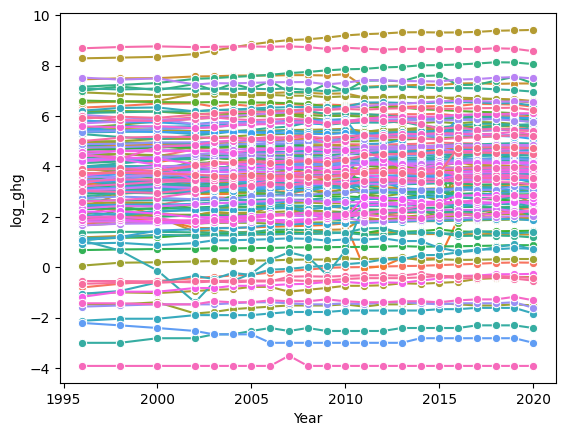

In [ ]:
sns.lineplot(data=ghg, x='Year', y='log_ghg', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

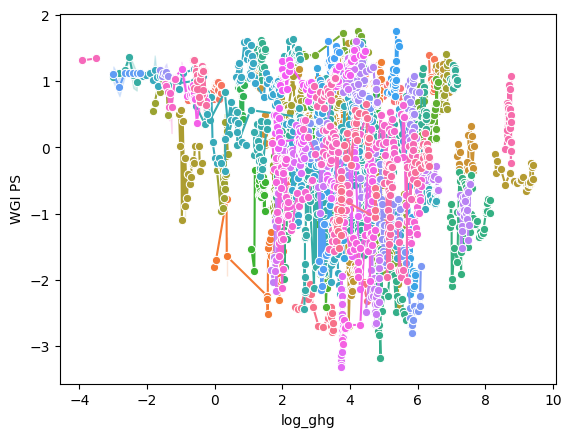

In [ ]:
sns.lineplot(data=ghg, x='log_ghg', y='WGI PS', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

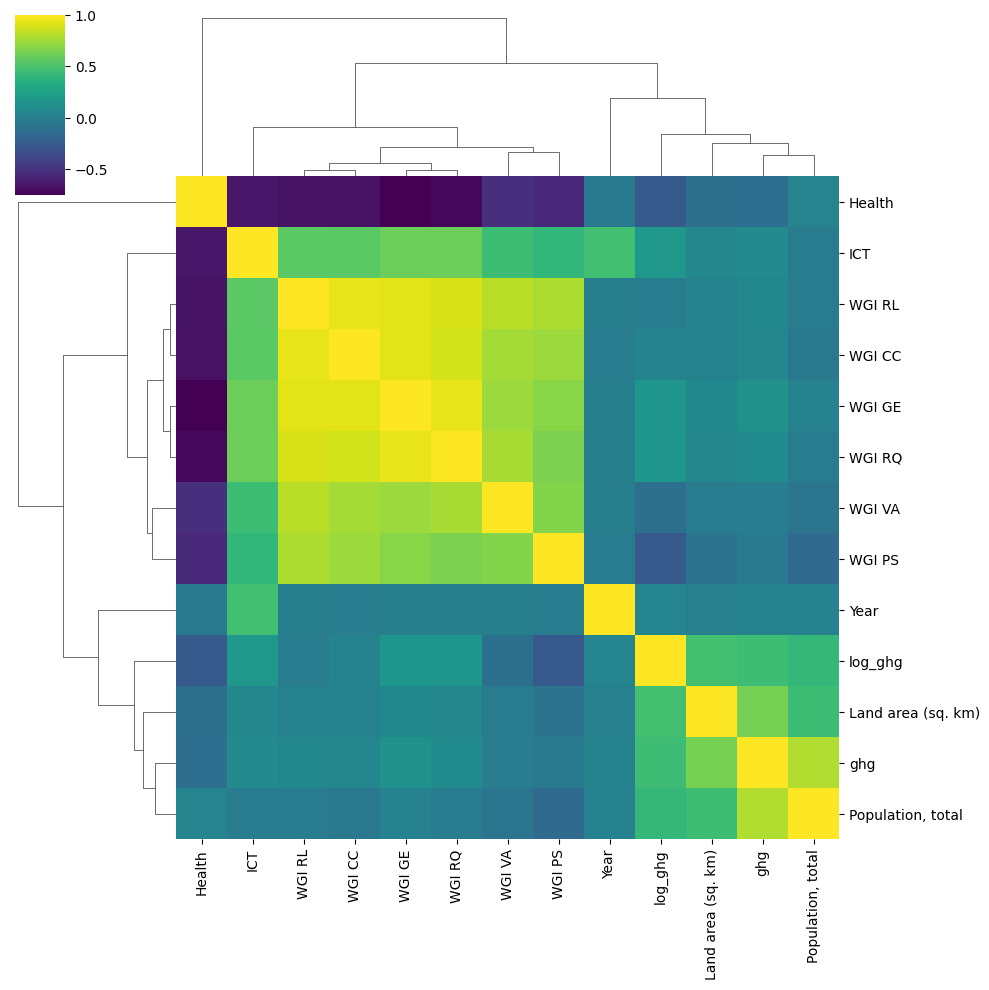

In [ ]:
ghg_num = ghg[ghg.select_dtypes(exclude=['object']).columns]

sns.clustermap(ghg_num.corr(), cmap='viridis')
plt.show()

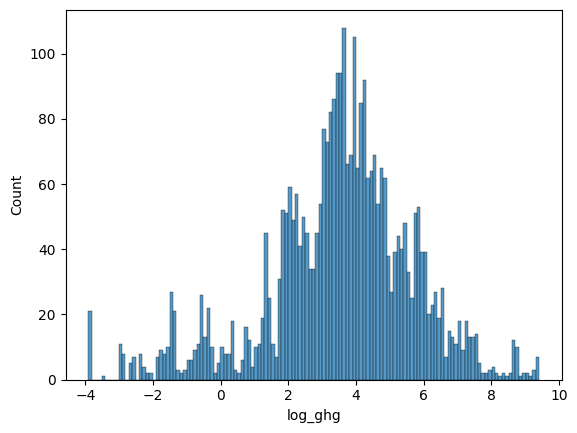

In [ ]:
sns.histplot(data=ghg, x='log_ghg', binwidth=0.1)
# Setting x-axis limit
#plt.xlim(left=-5)
#plt.xlim(right=10)
plt.show()

## Splitting the data set

Splitting the dataset into 70% training, 15% validation, 15% set. Then the Y variable must be lagged 4 years (not 5 to accomodate for the datastructure of 1996, 1998, 2000, 2002-2020). 

In [ ]:
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


In [ ]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'lagged_ghg' and initializing with NaN
ghg['lagged_ghg'] = pd.NA

#Iterating over each row
for i in range(len(ghg)):
    country = ghg.loc[i, 'Country Code']
    year = ghg.loc[i, 'Year']

    correct_year = year + lag_years
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = ghg[(ghg['Country Code'] == country) & (ghg['Year'] == correct_year)]
    
    #print(lagged_row['ghg'])
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        ghg.loc[i, 'lagged_ghg'] = lagged_row['log_ghg'].values[0]

#Display the new dataframe 
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298,4.729156
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267,<NA>
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913,<NA>
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938,<NA>


In [ ]:
#Checking if the lagged is correct 
print(ghg[(ghg['Country Code'] == 'ZWE') & (ghg['Year'] == 2000.0)]['log_ghg'])

print(ghg[(ghg['Country Code'] == 'ZWE') & (ghg['Year'] == 1996.0)]['lagged_ghg'])


3324    3.724729
Name: log_ghg, dtype: float64
3322    3.724729
Name: lagged_ghg, dtype: object


In [ ]:
ghg['lagged_ghg'] = pd.to_numeric(ghg['lagged_ghg'])
ghg = ghg.rename(columns={'Land area (sq. km)':'land_area'})
ghg = ghg.rename(columns={'Population, total':'population'})
ghg = ghg.dropna()

display(ghg)
ghg.info()

,Country Code,Country/Region,Year,ghg,log_ghg,population,land_area,WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,ZWE,Zimbabwe,2012.0,42.23,3.743131,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,4.747711
3336,ZWE,Zimbabwe,2013.0,42.19,3.742183,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,4.744932
3337,ZWE,Zimbabwe,2014.0,40.34,3.697344,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,4.760121
3338,ZWE,Zimbabwe,2015.0,41.86,3.734331,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,4.753849


<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3339
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    2736 non-null   object 
 1   Country/Region  2736 non-null   object 
 2   Year            2736 non-null   float64
 3   ghg             2736 non-null   float64
 4   log_ghg         2736 non-null   float64
 5   population      2736 non-null   float64
 6   land_area       2736 non-null   float64
 7   WGI VA          2736 non-null   float64
 8   WGI PS          2736 non-null   float64
 9   WGI GE          2736 non-null   float64
 10  WGI RQ          2736 non-null   float64
 11  WGI RL          2736 non-null   float64
 12  WGI CC          2736 non-null   float64
 13  ICT             2736 non-null   float64
 14  Health          2736 non-null   float64
 15  lagged_ghg      2736 non-null   float64
dtypes: float64(14), object(2)
memory usage: 363.4+ KB


In [ ]:
#Defining the features (X) and the target variable (y)
X = ghg.drop(columns=['Country/Region']) 
y = ghg['lagged_ghg'] 

#Defining the group variable (Country)
groups = ghg['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42) 
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]



In [ ]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1908, 15) (1908,)
Validation set shape: (414, 15) (414,)
Test set shape: (414, 15) (414,)


In [ ]:
print(X_train['lagged_ghg'])

0       2.469793
1       2.733068
2       2.753024
3       2.855895
4       2.909084
          ...   
3335    4.747711
3336    4.744932
3337    4.760121
3338    4.753849
3339    4.729156
Name: lagged_ghg, Length: 1908, dtype: float64


In [ ]:
ghg.isna().sum()

Country Code      0
Country/Region    0
Year              0
ghg               0
log_ghg           0
population        0
land_area         0
WGI VA            0
WGI PS            0
WGI GE            0
WGI RQ            0
WGI RL            0
WGI CC            0
ICT               0
Health            0
lagged_ghg        0
dtype: int64

In [ ]:
ghg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3339
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    2736 non-null   object 
 1   Country/Region  2736 non-null   object 
 2   Year            2736 non-null   float64
 3   ghg             2736 non-null   float64
 4   log_ghg         2736 non-null   float64
 5   population      2736 non-null   float64
 6   land_area       2736 non-null   float64
 7   WGI VA          2736 non-null   float64
 8   WGI PS          2736 non-null   float64
 9   WGI GE          2736 non-null   float64
 10  WGI RQ          2736 non-null   float64
 11  WGI RL          2736 non-null   float64
 12  WGI CC          2736 non-null   float64
 13  ICT             2736 non-null   float64
 14  Health          2736 non-null   float64
 15  lagged_ghg      2736 non-null   float64
dtypes: float64(14), object(2)
memory usage: 363.4+ KB


## Baseline simple model 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
ghg_model = ghg

In [ ]:
ghg_model['lagged_ghg'] = pd.to_numeric(ghg_model['lagged_ghg'])
ghg_model = ghg_model.rename(columns={'Land area (sq. km)':'land_area'})
ghg_model = ghg_model.rename(columns={'Population, total':'population'})
ghg_model = ghg_model.dropna()

In [134]:
dummy = smf.mixedlm(
        formula='''lagged_ghg ~ population + Year + land_area''',
        data=ghg_model,
        groups=ghg_model['Country Code']).fit()

dummy.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: lagged_ghg
No. Observations:  2736    Method:             REML      
No. Groups:        152     Scale:              0.0533    
Min. group size:   18      Log-Likelihood:     -451.3412 
Max. group size:   18      Converged:          Yes       
Mean group size:   18.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  -20.492    1.609 -12.733 0.000 -23.646 -17.337
population   0.000    0.000   5.564 0.000   0.000   0.000
Year         0.012    0.001  14.755 0.000   0.010   0.013
land_area    0.000    0.000   5.649 0.000   0.000   0.000
Group Var    3.518    1.814                              
=========================================================

"""

<Figure size 2000x1500 with 0 Axes>

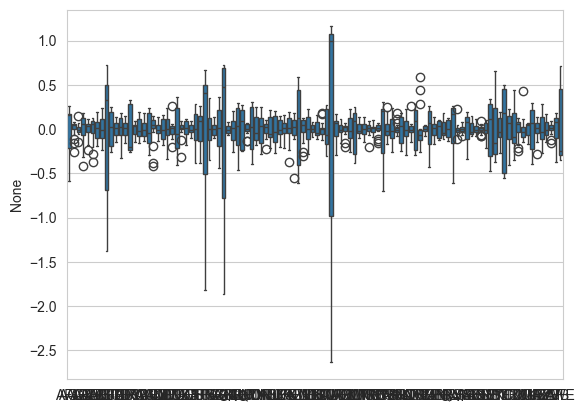

<Figure size 2000x1500 with 0 Axes>

In [127]:

sns.boxplot(x = dummy.model.groups, y = dummy.resid)
plt.figure(figsize = (20, 15))

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pickle as pkl

# Assuming ghg_model is already defined and contains the relevant columns
# Split the data into training, validation, and test sets (X_train, X_val, X_test, y_train, y_val, y_test)
# Assuming these splits are already done as per your previous context

performances = []

# Define the model name
model_name = "simple_ghg"

# Define the formula for the mixed effects model
formula = 'lagged_ghg ~ Year + population + land_area'

# Fit the mixed effects model
dummy = smf.mixedlm(formula=formula, data=X_train, groups=X_train['Country Code']).fit()

# Save the model
with open('ghg_mixedlm.pkl', 'wb') as file:
    pkl.dump(dummy, file)

# Initialize a list to store performance metrics
performances = []

# Define a function to predict using the mixed effects model
def predict_mixedlm(model, df):
    df = df.copy()
    df['prediction'] = model.predict(df)
    return df['prediction']

# Evaluate the model on train, validation, and test sets
for x, y, nsplit, name in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Predict using the mixed effects model
    preds = predict_mixedlm(dummy, x)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model_name,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4),
        'r2': round(r2, 4)
    })

# Display the performance metrics
for performance in performances:
    print(performance)


{'model': 'simple_ghg', 'split': 'train', 'rmse': 1.7968, 'mae': 1.2745, 'mape': 7915583082554.371, 'r2': 0.3149}
{'model': 'simple_ghg', 'split': 'val', 'rmse': 2.3295, 'mae': 1.5638, 'mape': 1.3268, 'r2': -0.3462}
{'model': 'simple_ghg', 'split': 'test', 'rmse': 1.8445, 'mae': 1.579, 'mape': 2.6598, 'r2': 0.1411}


In [ ]:
perf_df = pd.DataFrame(performances)

C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)
C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: UserWarning: The palette list has more values (152) than needed (30), which may not be intended.
  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)


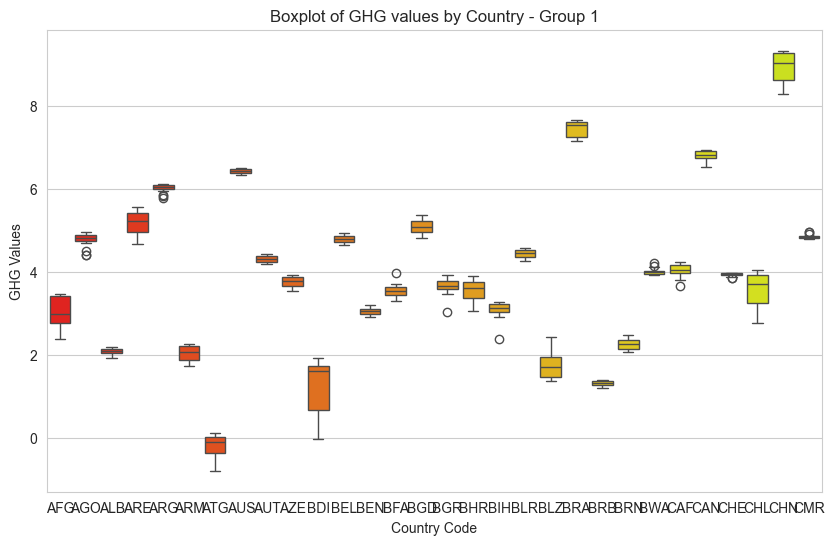

C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)
C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: UserWarning: The palette list has more values (152) than needed (30), which may not be intended.
  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)


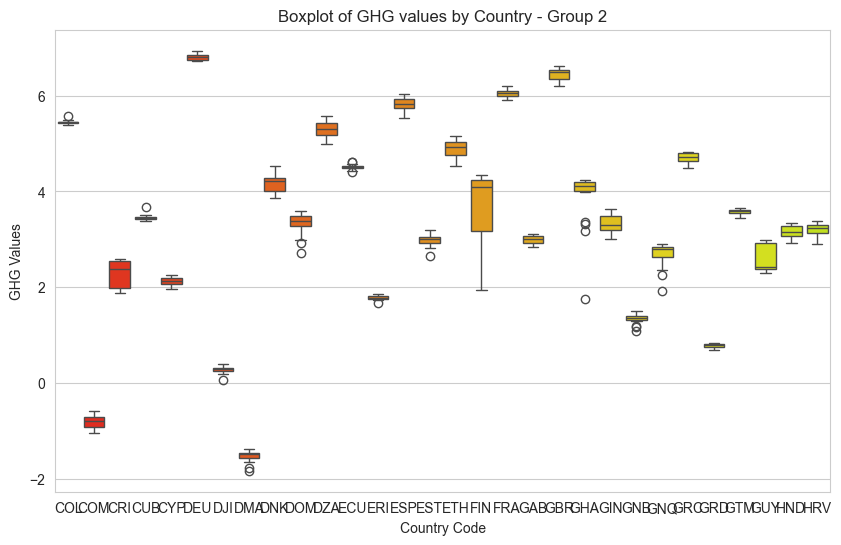

C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)
C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: UserWarning: The palette list has more values (152) than needed (30), which may not be intended.
  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)


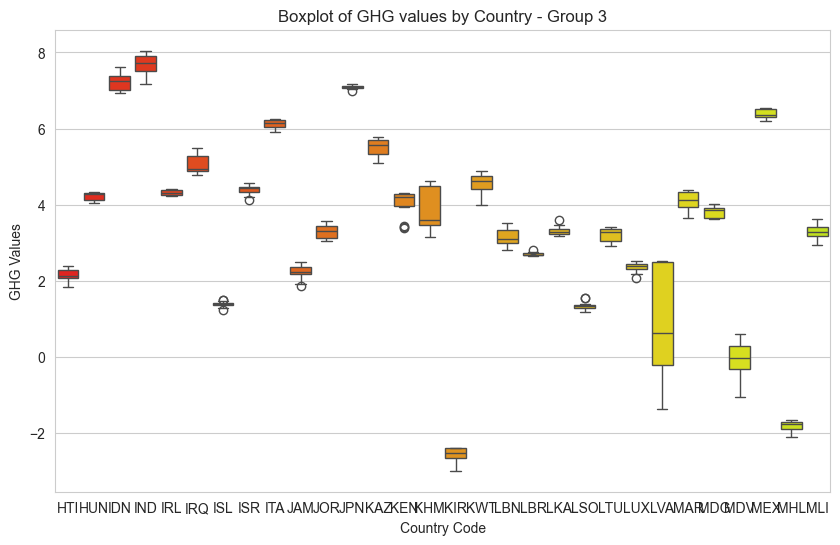

C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)
C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: UserWarning: The palette list has more values (152) than needed (30), which may not be intended.
  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)


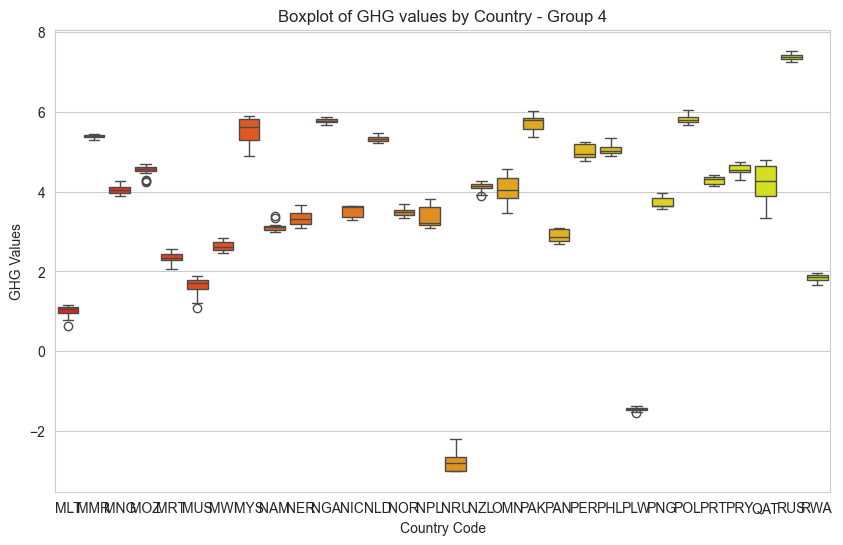

C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)
C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: UserWarning: The palette list has more values (152) than needed (30), which may not be intended.
  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)


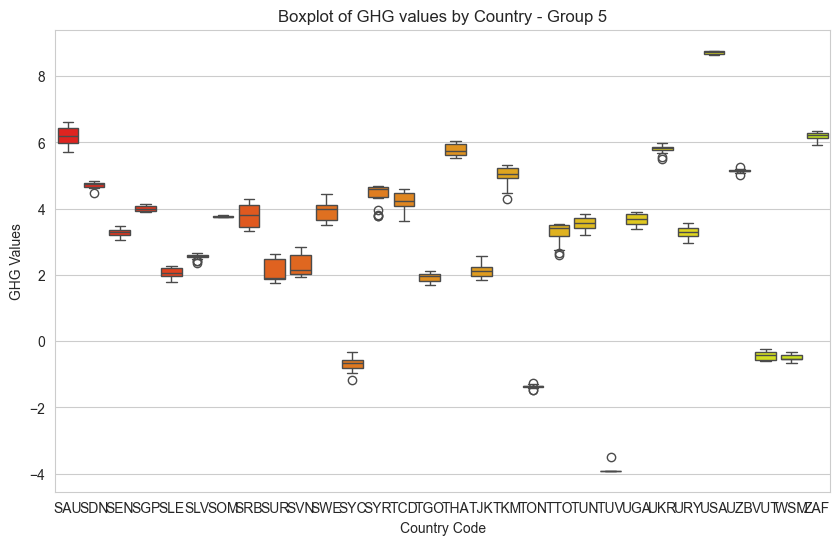

C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)
C:\Users\mlj\AppData\Local\Temp\ipykernel_13500\4139826879.py:11: UserWarning: The palette list has more values (152) than needed (2), which may not be intended.
  sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)


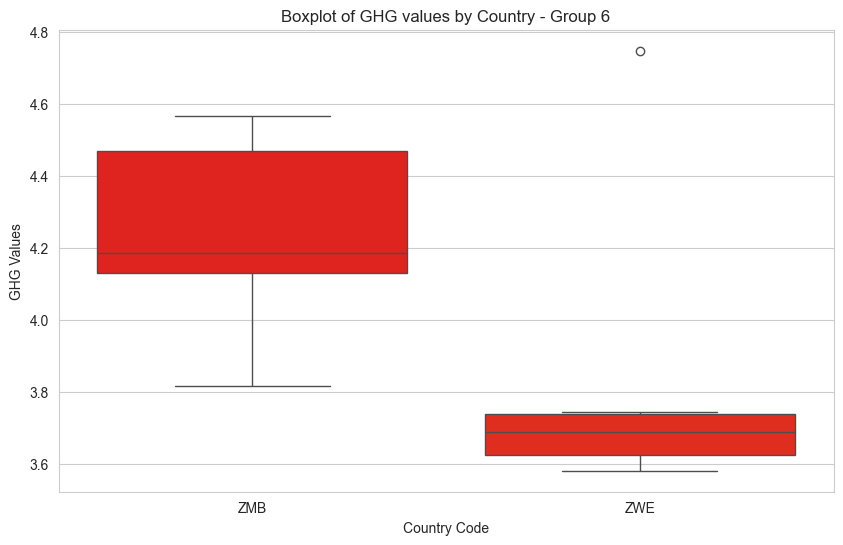

In [122]:
countries = ghg['Country Code'].unique()
countries_per_fig = 30
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

# Create the boxplots
for i, group in enumerate(country_groups):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Country Code', y='log_ghg', data=ghg[ghg['Country Code'].isin(group)], palette=palette)
    plt.title(f'Boxplot of GHG values by Country - Group {i + 1}')
    plt.xlabel('Country Code')
    plt.ylabel('GHG Values')
    plt.show()

In [ ]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

## Baseline model 

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
import pickle as pkl

In [ ]:
model_name = 'dummy'

for y, nsplit in zip([y_train, y_val, y_test], ['train', 'val', 'test']):
    # Get indices where 'NaN' values are present in the 'log_ghg' column
    nan_indices = np.where(y.isnull())[0].tolist()
    # Ignore rows with NaN values
    y_filtered = y.dropna()
    # Calculate mean value of the target variable
    mean_value = y_filtered.mean()
    
    performance = np.sqrt(mean_squared_error(y_filtered, [mean_value]*len(y_filtered)))
    r2 = r2_score(y_filtered, [mean_value]*len(y_filtered))
    performances.append({
        'model': model_name,
        'split': nsplit,
        'rmse': performance.round(4),
        'r2': r2.round(4)
    })

## Mixed Effects Linear Regressor

In [ ]:
model_name = Government Readiness MELF

#Now let's fit a linear model with only theoretical predictors

gov_preds = [3, 6, 7, 10, 11, 12]

reg = LinearRegression().fit(X_train[:,gov_preds], y_train)
pkl.dump(reg, file=open(f'ghg_MELF.pkl', 'wb')) # save the model
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x[:,gov_preds])
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-demographics',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [ ]:
countries = ghg_full['Country Code']

0       CHN
1       USA
2       IND
3       RUS
4       IDN
       ... 
6114    COK
6115    NRU
6116    TUV
6117    NIU
6118    FJI
Name: Country Code, Length: 6119, dtype: object

In [ ]:
display(X_train)

,Country Code,Year,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT
3438,HND,2007.0,7924462.0,111890.00,-0.192797,-0.437030,-0.553879,-0.282702,-0.928943,-0.791543,NaN,NaN,2.8,NaN
1763,FRA,1999.0,60504420.0,547566.00,NaN,NaN,NaN,NaN,NaN,NaN,53.005081,13592.0,7.7,31.633476
5564,NLD,2018.0,17231624.0,33670.00,1.499295,0.838097,1.809711,2.013644,1.744731,1.888952,83.652473,2111.0,8.9,66.363177
3515,NRU,2007.0,10267.0,20.00,1.056957,1.088966,-0.584644,-0.697122,0.502609,-0.356638,NaN,NaN,NaN,NaN
5108,DMA,2015.0,70007.0,750.00,0.878904,1.054432,0.213033,0.240543,0.701885,0.606967,NaN,NaN,NaN,53.803960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,CHE,1991.0,6799978.0,39529.35,NaN,NaN,NaN,NaN,NaN,NaN,27.169800,2949.0,NaN,NaN
4595,IRL,2013.0,4623816.0,68890.00,1.311735,0.901076,1.504589,1.574062,1.709155,1.646098,NaN,NaN,7.3,58.871023
963,CAN,1995.0,29302311.0,8965590.00,NaN,NaN,NaN,NaN,NaN,NaN,90.464058,2431.0,7.3,NaN
4426,GTM,2012.0,14781942.0,107160.00,-0.356139,-0.633820,-0.787667,-0.263001,-1.083920,-0.678763,16.934290,7.0,NaN,50.261684


In [ ]:
# Assuming you have a list of countries
country_codes = ghg_full['Country Code']

gov_preds = [3, 6, 7, 10, 11, 12]
country_performances = []



for country in country_codes:
    # Filter data for the current country
    X_train_country = X_train[X_train['Country Code'] == country]
    X_val_country = X_val[X_val['Country Code'] == country]
    X_test_country = X_test[X_test['Country Code'] == country]
    y_train_country = y_train[X_train['Country Code'] == country]
    y_val_country = y_val[X_val['Country Code'] == country]
    y_test_country = y_test[X_test['Country Code'] == country]
    
    # Filter columns by indices
    X_train_country_filtered = X_train_country.iloc[:, gov_preds]
    X_val_country_filtered = X_val_country.iloc[:, gov_preds]
    X_test_country_filtered = X_test_country.iloc[:, gov_preds]
    
    # Train linear regression model
    reg = LinearRegression().fit(X_train_country_filtered, y_train_country)
    
    # Save the model
    with open(f'{country}_gov_MELF.pkl', 'wb') as f:
        pkl.dump(reg, f)
    
    for X, y, split in zip([X_train_country, X_val_country, X_test_country],
                           [y_train_country, y_val_country, y_test_country],
                           ['train', 'val', 'test']):
        preds = reg.predict(X[:, gov_preds])
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'linear-{country}',
                             'split': split,
                             'rmse': performance.round(4),
                             'r2': r2.round(4)})


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## MERF Model

In [ ]:
!pip install merf


  Using cached merf-1.0-py3-none-any.whl.metadata (5.2 kB)
Using cached merf-1.0-py3-none-any.whl (14 kB)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import merf
from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
#Assigning x and y 
X = ghg_full.iloc[:, [0] + [3] + [5] + list(range(7, 18))] # year, log, and pop+
y = ghg_full['log_ghg']  # Selecting the column containing the target variable

In [ ]:
display(ghg_full)

,Country Code,Country/Region,unit,Year,ghg,log_ghg,Country Name,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845,China,1.135185e+09,9388250.0,NaN,NaN,NaN,NaN,NaN,NaN,3.001490,5832.0,8.3,NaN
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140,United States,2.496230e+08,9158960.0,NaN,NaN,NaN,NaN,NaN,NaN,69.676811,90643.0,5.6,NaN
2,IND,India,MtCO2e,1990.0,1020.11,6.927666,India,8.704522e+08,2973190.0,NaN,NaN,NaN,NaN,NaN,NaN,5.851950,1147.0,NaN,NaN
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737,Russian Federation,1.479694e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.920052,NaN,NaN,NaN
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520,Indonesia,1.821599e+08,1811570.0,NaN,NaN,NaN,NaN,NaN,NaN,8.385050,NaN,8.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260,Cook Islands,NaN,NaN,1.069792,1.151947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6115,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,Nauru,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN
6116,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023,Tuvalu,1.106900e+04,30.0,1.173426,1.218199,-0.430198,-0.317362,0.650381,0.484759,NaN,NaN,NaN,NaN
6117,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702,Niue,NaN,NaN,1.267860,1.362529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

In [ ]:
display(X_train)

,Country Code,Year,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality
3438,HND,2007.0,3.158276,7924462.0,111890.00,-0.192797,-0.437030,-0.553879,-0.282702,-0.928943,-0.791543,NaN,NaN,2.8
1763,FRA,1999.0,6.181320,60504420.0,547566.00,NaN,NaN,NaN,NaN,NaN,NaN,53.005081,13592.0,7.7
5564,NLD,2018.0,5.217270,17231624.0,33670.00,1.499295,0.838097,1.809711,2.013644,1.744731,1.888952,83.652473,2111.0,8.9
3515,NRU,2007.0,-2.995732,10267.0,20.00,1.056957,1.088966,-0.584644,-0.697122,0.502609,-0.356638,NaN,NaN,NaN
5108,DMA,2015.0,-1.427116,70007.0,750.00,0.878904,1.054432,0.213033,0.240543,0.701885,0.606967,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,CHE,1991.0,3.992127,6799978.0,39529.35,NaN,NaN,NaN,NaN,NaN,NaN,27.169800,2949.0,NaN
4595,IRL,2013.0,4.237723,4623816.0,68890.00,1.311735,0.901076,1.504589,1.574062,1.709155,1.646098,NaN,NaN,7.3
963,CAN,1995.0,6.502370,29302311.0,8965590.00,NaN,NaN,NaN,NaN,NaN,NaN,90.464058,2431.0,7.3
4426,GTM,2012.0,3.510052,14781942.0,107160.00,-0.356139,-0.633820,-0.787667,-0.263001,-1.083920,-0.678763,16.934290,7.0,NaN


In [ ]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
# Define the model name
model_name = "Government Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.iloc[:, 1:]

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test']):
    preds = merf.predict(x[:, gov_preds], z, clusters)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({
        'model': 'merf-demographics',
        'split': nsplit,
        'rmse': performance.round(4),
        'r2': r2.round(4)
    })

# Print the performance metrics
for performance in performances:
    print(performance)

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values